In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install np_utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 614.3 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for np_utils: filename=np_utils-0.6.0-py3-none-any.whl size=56439 sha256=1ff933b0c08ed32cd33a040931fd90e657b5f39425b0063d1df6bb6e2752d23b
  Stored in directory: /root/.cache/pip/wheels/b6/c7/50/2307607f44366dd021209f660045f8d51cb976514d30be7cc7
Successfully built np_utils


# LIB IMPORT

In [2]:
import tensorflow as tf
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential
import np_utils
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Reshape, Dropout
import pandas as pd
import numpy as np
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt

2024-06-13 14:08:08.200647: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-13 14:08:08.200748: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-13 14:08:08.294237: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# SETTING CONSTANTS

In [3]:
TRAIN_IMG = "/kaggle/input/melanoma-cancer-dataset/train"
TEST_IMG = "/kaggle/input/melanoma-cancer-dataset/test"
N_CLASS = 2
BATCH = 32
ROWS = 224
COLS = 224
SHAPE = (ROWS, COLS, 3)
EPOCHS = 15
TRAIN_SAMPLES = 3000
TEST_SAMPLES = 3000

# PREPROCESS

In [4]:
train_gen = ImageDataGenerator(rescale=1/.512).flow_from_directory(directory=TRAIN_IMG,
                                                                 class_mode='categorical',
                                                                 batch_size=BATCH,
                                                                 target_size=(ROWS, COLS),
                                                                 color_mode='rgb',
                                                                 shuffle=True)
test_gen = ImageDataGenerator(rescale=1/.512).flow_from_directory(directory=TEST_IMG,
                                                                 class_mode='categorical',
                                                                 batch_size=BATCH,
                                                                 target_size=(ROWS, COLS),
                                                                 color_mode='rgb',
                                                                 shuffle=False)

Found 11879 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


# BUILDING CNN MODEL

In [5]:
from keras.optimizers import Adam

def CNN(layers = 3, filters = 32, filters_size = (3, 3), init = 'glorot_uniform', active_func = 'relu',do=0.2, opt='RMSprop'):
    
    model = Sequential()
    for i in range(0, layers):
        model.add(Conv2D(filters, filters_size, activation=active_func, input_shape=SHAPE))
        model.add(MaxPooling2D(2, 2))
#         model.add(Dropout(do))
    
    model.add(Flatten())
    model.add(Dense(512, activation=active_func))
    model.add(Dense(N_CLASS, activation='softmax'))
    
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    
    return model


# Add Confusion Matrix

In [6]:
import matplotlib.pyplot as plt
import itertools

def Evaluate(confusion, class_names, normalize=True, title="Evaluation", cmap=plt.cm.Blues):
    plt.figure(figsize=(8,8))
    plt.imshow(confusion, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tm = np.arange(len(class_names))
    plt.xticks(tm, class_names, rotation=45)
    plt.yticks(tm, class_names)
    
    if normalize:
        confusion = confusion.astype('float')/confusion.sum(axis=1)[:, np.newaxis]
        confusion = np.around(confusion, decimals=2)
        confusion[np.isnan(confusion)] = 0.0
        print("normal ConfMatrix")
    else:
        print("no normal ConfMatrix")
    
    thresh = confusion.max()/2
    for i, j in itertools.product(range(confusion.shape[0]), range(confusion.shape[1])):
        plt.text(j, i, confusion[i, j],
                horizontalalignment='center',
                color='white' if confusion[i, j] > thresh else 'black'
                )
    
    plt.tight_layout()
    plt.ylabel('true label')
    plt.xlabel('predicted label')
    plt.show()
    
    
    

# Add Train and Loss graph

In [7]:
def plot_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
    
    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')
    
    plt.tight_layout()
    plt.show()

In [8]:
from sklearn.metrics import confusion_matrix, classification_report
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error

def trainAndEval(model, epoch):
    # early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
    history = model.fit(train_gen, epochs=epoch, steps_per_epoch=30, validation_data = test_gen)
    
    loss_and_metrics = model.evaluate(test_gen, steps=20)
    print("Loss: ", loss_and_metrics[0])
    print("Accuracy: ", loss_and_metrics[1])
    test_gen.reset()
    
    Y_pred = model.predict(test_gen, steps=TEST_SAMPLES // BATCH + 1)
    y_pred = np.argmax(Y_pred, axis=1)
    
    class_names = []
    for key in train_gen.class_indices:
        class_names.append(key)
        
    cr = classification_report(test_gen.classes, y_pred, target_names=class_names)
    print("Class Report\n" + cr)
    confusion = confusion_matrix(test_gen.classes, y_pred)

    Evaluate(confusion, class_names, normalize=True, title='Evaluation')
    Evaluate(confusion, class_names, normalize=False, title='Evaluation')
    
    plot_history(history)
    
    return model

In [ ]:
# # 2nd best, w/o early stopping
# model = CNN(layers=3, filters=64, filters_size=(2,2), active_func='relu')
# model = trainAndEval(model, epoch=30)

# Other Trials
the models below is just for experiment purpose only

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 223, 223, 32)   │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 110, 110, 32)   │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 55, 55, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 54, 54, 32)     │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 27, 27, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 23328)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │    11,944,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,954,146 (45.60 MB)

 Trainable params: 11,954,146 (45.60 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/35
 4/30 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.5488 - loss: 252.3657

W0000 00:00:1718288566.845790     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.5441 - loss: 152.1828

W0000 00:00:1718288569.414550     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 231ms/step - accuracy: 0.5433 - loss: 147.4656 - val_accuracy: 0.5000 - val_loss: 43.9047
Epoch 2/35
 4/30 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.4674 - loss: 49.8274

W0000 00:00:1718288573.551354     139 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 165ms/step - accuracy: 0.5308 - loss: 37.6621 - val_accuracy: 0.6915 - val_loss: 3.2714
Epoch 3/35
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 167ms/step - accuracy: 0.6850 - loss: 8.2502 - val_accuracy: 0.7390 - val_loss: 2.5629
Epoch 4/35
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 0.7698 - loss: 2.7097 - val_accuracy: 0.5980 - val_loss: 8.1805
Epoch 5/35
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 0.7334 - loss: 3.6331 - val_accuracy: 0.6165 - val_loss: 5.6479
Epoch 6/35
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 0.7332 - loss: 3.2124 - val_accuracy: 0.7070 - val_loss: 2.6184
Epoch 7/35
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 0.6859 - loss: 6.1205 - val_accuracy: 0.7490 - val_loss: 2.2971
Epoch 8/35
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 0.7042 - loss: 4.8807 - val_accuracy: 0.6615 - val_loss: 5.6525
Epoch 9/35
25/30 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.7548 - loss: 3.7591

W0000 00:00:1718288606.663762     139 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 224ms/step - accuracy: 0.7612 - loss: 3.6034 - val_accuracy: 0.7825 - val_loss: 1.7794
Epoch 10/35
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.8309 - loss: 1.4883 - val_accuracy: 0.7950 - val_loss: 1.3959
Epoch 11/35
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 0.7728 - loss: 2.3346 - val_accuracy: 0.5440 - val_loss: 5.8870
Epoch 12/35
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 0.7122 - loss: 3.5499 - val_accuracy: 0.7450 - val_loss: 2.0423
Epoch 13/35
11/30 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8449 - loss: 1.3977

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.8079 - loss: 1.7538 - val_accuracy: 0.5685 - val_loss: 9.8705
Epoch 14/35
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 173ms/step - accuracy: 0.7217 - loss: 3.7625 - val_accuracy: 0.8350 - val_loss: 0.9384
Epoch 15/35
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 171ms/step - accuracy: 0.8331 - loss: 1.1229 - val_accuracy: 0.7570 - val_loss: 1.5449
Epoch 16/35
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 168ms/step - accuracy: 0.7817 - loss: 2.4467 - val_accuracy: 0.7430 - val_loss: 2.0495
Epoch 17/35
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 171ms/step - accuracy: 0.7935 - loss: 2.3241 - val_accuracy: 0.8125 - val_loss: 1.1699
Epoch 18/35
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 0.8372 - loss: 1.0659 - val_accuracy: 0.7810 - val_loss: 1.1572
Epoch 19/35
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 0.7153 - loss: 3.2502 - val_accuracy: 0.8495 - val_loss: 0.9504
Epoch 20/35
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 0.8750 - loss: 0.9714 - val_accuracy: 0.6965

W0000 00:00:1718288726.574999     137 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step


W0000 00:00:1718288729.947020     139 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Class Report
              precision    recall  f1-score   support

      Benign       0.89      0.85      0.87      1000
   Malignant       0.86      0.89      0.88      1000

    accuracy                           0.87      2000
   macro avg       0.87      0.87      0.87      2000
weighted avg       0.87      0.87      0.87      2000

normal ConfMatrix


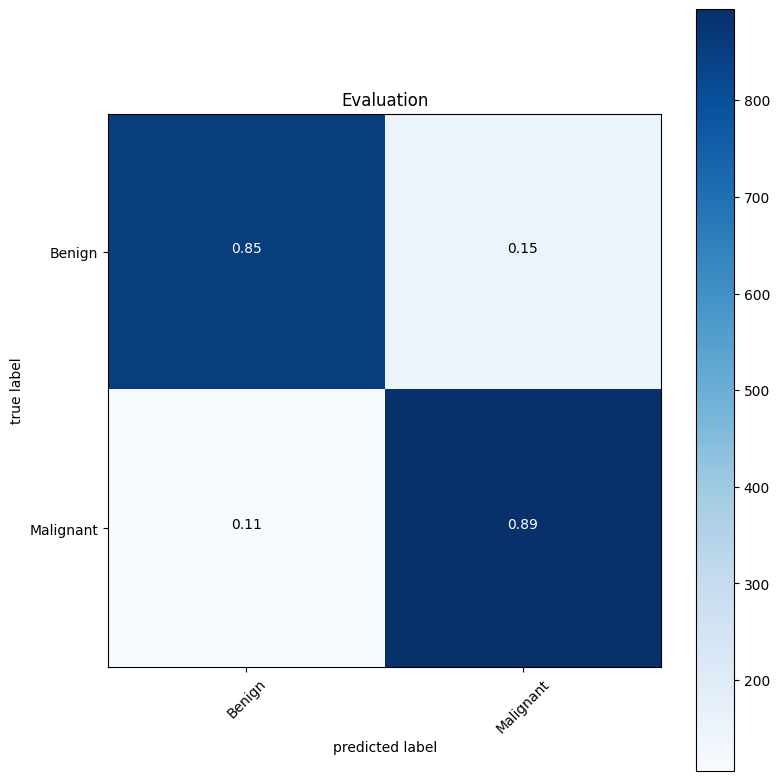

no normal ConfMatrix


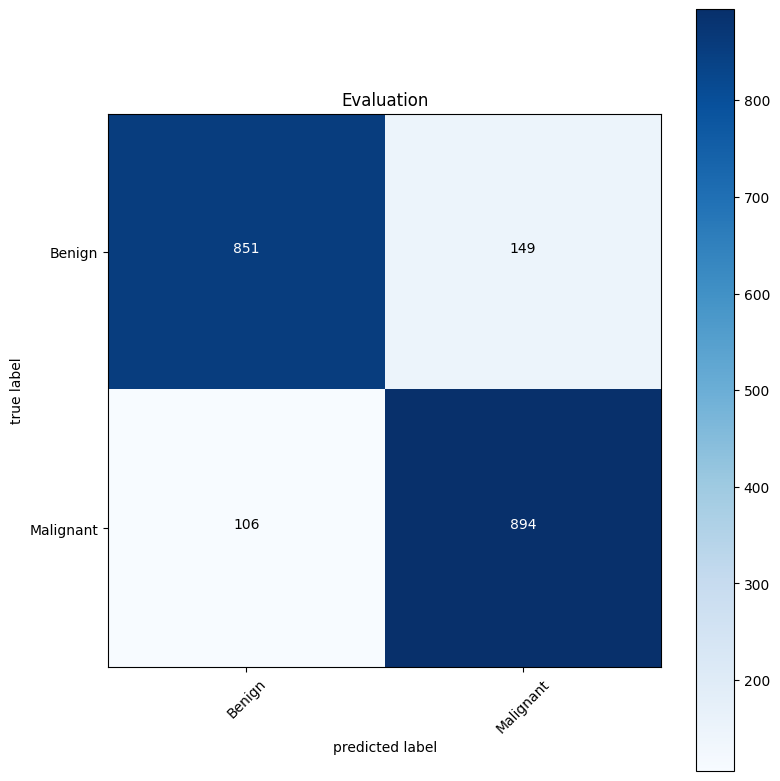

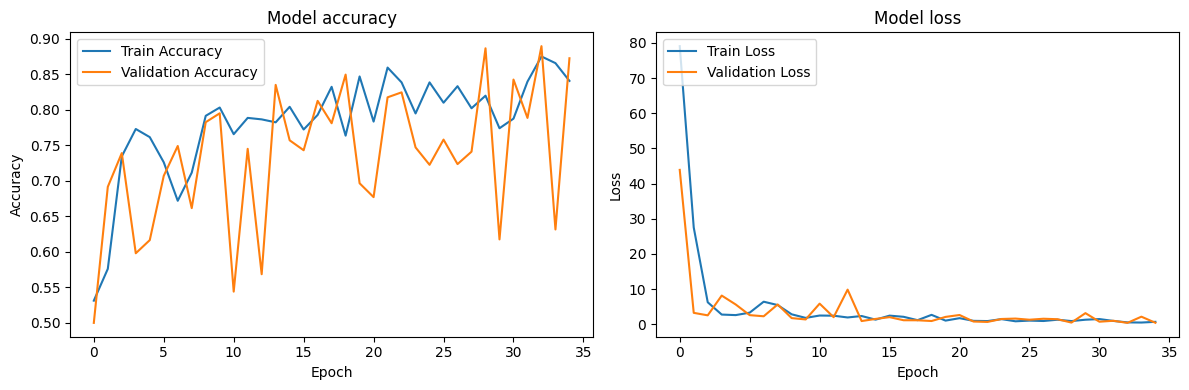

In [11]:
# on lead, current best model by 020624 at 14.24, wo early stopping
from keras.optimizers import Ftrl
model = CNN(layers=3, filters=32, filters_size=(2, 2), active_func='relu', opt=Adam(learning_rate=1e-4))
model = trainAndEval(model, epoch=35)


In [12]:
tf.keras.models.save_model(model, "cnnMelanomaX.hdf5")

In [ ]:
# model.save_weights("cnn-melanoma.weights.h5")

In [13]:
from IPython.display import FileLink

# Display a download link for the file
FileLink(r'cnnMelanomaX.hdf5')

/kaggle/working/cnnMelanomaX.hdf5

In [ ]:
# tf.keras.models.save_model(model, "cnnMelanoma.hdf5")

In [ ]:
# # 4th best model

# model = CNN(layers=3, filters=48, filters_size=(2,2), active_func='relu')
# model = trainAndEval(model, epoch=40)

In [ ]:
# # 3rd best model from previous, winning by recall and f score
# model = CNN(layers=3, filters=48, filters_size=(3,3), active_func='relu')
# model = trainAndEval(model, epoch=40)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    95,552,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,591,746 (364.65 MB)

 Trainable params: 95,591,746 (364.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/35


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 1/30 ━━━━━━━━━━━━━━━━━━━━ 4:40 10s/step - accuracy: 0.5714 - loss: 12.8713

I0000 00:00:1717928426.860000     135 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1717928426.877659     135 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 3/30 ━━━━━━━━━━━━━━━━━━━━ 1:46 4s/step - accuracy: 0.5351 - loss: 850.6989

W0000 00:00:1717928434.650021     134 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.5113 - loss: 652.7521

W0000 00:00:1717928441.371473     134 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


30/30 ━━━━━━━━━━━━━━━━━━━━ 38s 960ms/step - accuracy: 0.5134 - loss: 642.4907 - val_accuracy: 0.6970 - val_loss: 13.9895
Epoch 2/35
 2/30 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.7109 - loss: 10.0719

W0000 00:00:1717928454.723159     136 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 334ms/step - accuracy: 0.7352 - loss: 10.1071 - val_accuracy: 0.6135 - val_loss: 7.3010
Epoch 3/35
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 308ms/step - accuracy: 0.7708 - loss: 4.9528 - val_accuracy: 0.7895 - val_loss: 2.8475
Epoch 4/35
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 286ms/step - accuracy: 0.7554 - loss: 4.0358 - val_accuracy: 0.6850 - val_loss: 5.2593
Epoch 5/35
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 250ms/step - accuracy: 0.7301 - loss: 6.3349 - val_accuracy: 0.7765 - val_loss: 2.2828
Epoch 6/35
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 243ms/step - accuracy: 0.7761 - loss: 2.7621 - val_accuracy: 0.6785 - val_loss: 5.4813
Epoch 7/35
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 235ms/step - accuracy: 0.7751 - loss: 4.0140 - val_accuracy: 0.7210 - val_loss: 2.6764
Epoch 8/35
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 241ms/step - accuracy: 0.7803 - loss: 2.2935 - val_accuracy: 0.8460 - val_loss: 0.8788
Epoch 9/35
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 241ms/step - accuracy: 0.8308 - loss: 1.0656 - val_accuracy: 0.8045 - va

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 175ms/step - accuracy: 0.8702 - loss: 0.3214 - val_accuracy: 0.8325 - val_loss: 0.5051
Epoch 14/35
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 260ms/step - accuracy: 0.8689 - loss: 0.3901 - val_accuracy: 0.8240 - val_loss: 0.4686
Epoch 15/35
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 275ms/step - accuracy: 0.8480 - loss: 0.4205 - val_accuracy: 0.8025 - val_loss: 0.5052
Epoch 16/35
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 259ms/step - accuracy: 0.8620 - loss: 0.3544 - val_accuracy: 0.8255 - val_loss: 0.4396
Epoch 17/35
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 262ms/step - accuracy: 0.8765 - loss: 0.3278 - val_accuracy: 0.7995 - val_loss: 0.4883
Epoch 18/35
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 236ms/step - accuracy: 0.8800 - loss: 0.3684 - val_accuracy: 0.8735 - val_loss: 0.3679
Epoch 19/35
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 228ms/step - accuracy: 0.8550 - loss: 0.3230 - val_accuracy: 0.8630 - val_loss: 0.4114
Epoch 20/35
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 228ms/step - accuracy: 0.8626 - loss: 0.3142 - val_accuracy: 0.8315

W0000 00:00:1717928698.213605     135 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step


W0000 00:00:1717928702.857914     137 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Class Report
              precision    recall  f1-score   support

      Benign       0.81      0.94      0.87      1000
   Malignant       0.93      0.78      0.85      1000

    accuracy                           0.86      2000
   macro avg       0.87      0.86      0.86      2000
weighted avg       0.87      0.86      0.86      2000

normal ConfMatrix


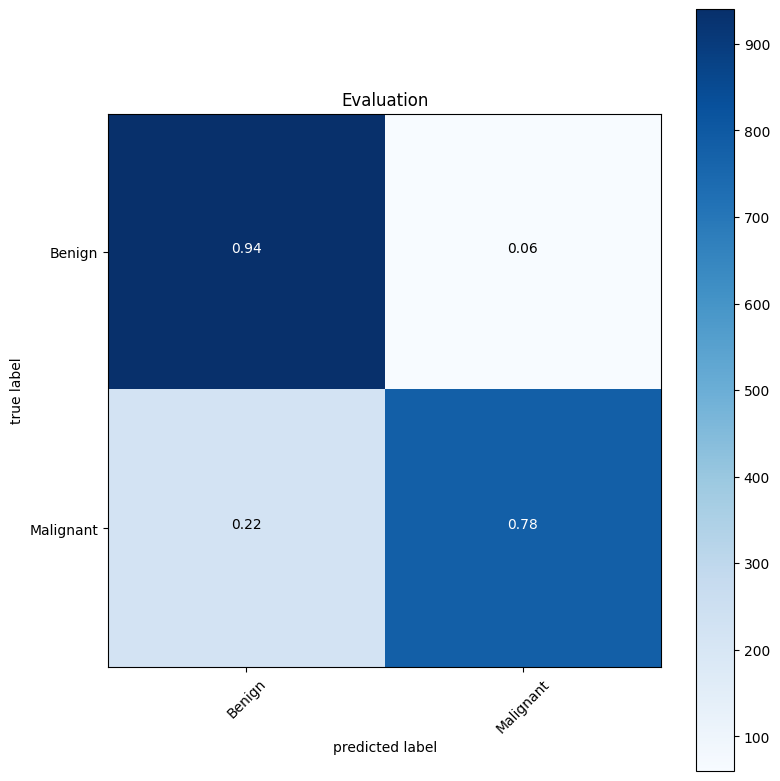

no normal ConfMatrix


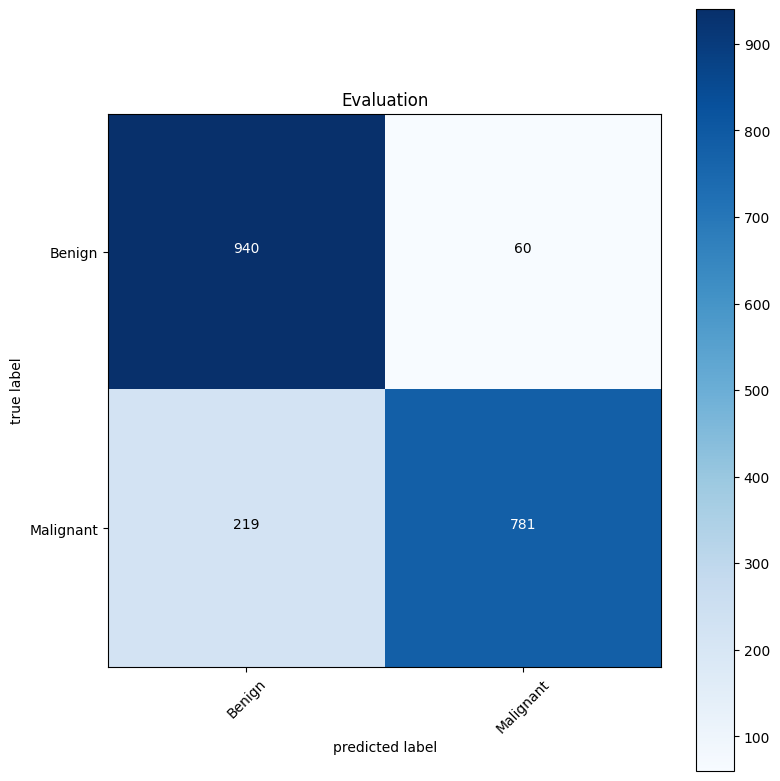

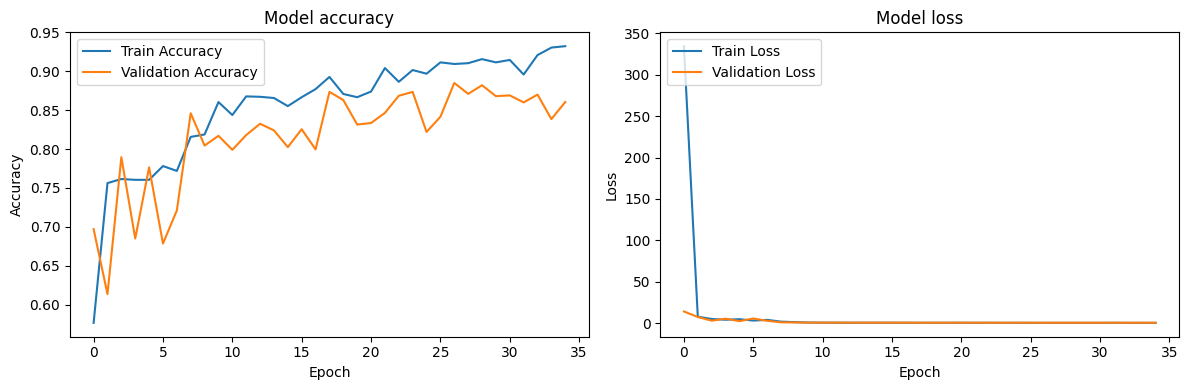

In [9]:
model = CNN(layers=2, filters=64, filters_size=(3,3), active_func='relu')
model = trainAndEval(model, epoch=35)

In [10]:
import pickle

pickle_out = open("cnnModel.pkl", "wb") 
pickle.dump(model, pickle_out) 
pickle_out.close()

In [11]:
from IPython.display import FileLink

# Display a download link for the file
FileLink(r'cnnModel.pkl')

/kaggle/working/cnnModel.pkl

In [ ]:
# model.save("melanoma3rdCNN.h5")